<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Banglore</h1>

Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

<h2 style='color:blue'>Data Load: Load banglore home prices into a dataframe</h2>

In [79]:
df1 = pd.read_csv("bengaluru_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [80]:
df1.shape

(13320, 9)

In [81]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [82]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [83]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

**Drop features that are not required to build our model**

In [84]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [85]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [86]:
df2.shape

(13320, 5)

In [87]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [88]:
df3.shape

(13246, 5)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [89]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\KIIT\AppData\Local\Temp\ipykernel_1568\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

**Explore total_sqft feature**

In [90]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [91]:
2+3

5

In [92]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [93]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [94]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [95]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [96]:
(2100+2850)/2

2475.0

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [97]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


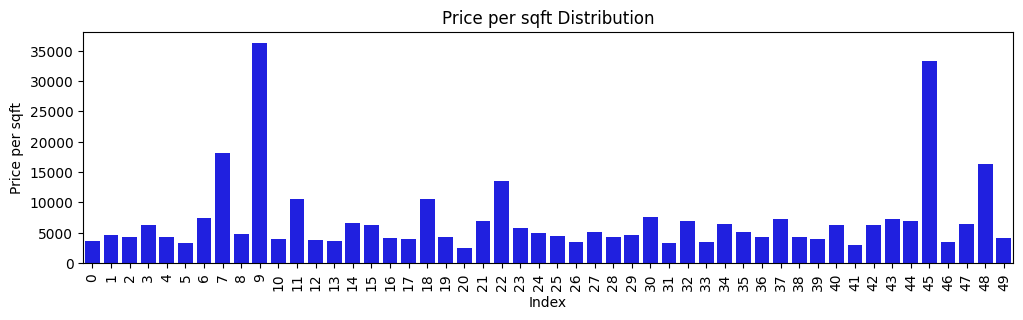

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 3))
sns.barplot(x=df5.index[:50], y=df5['price_per_sqft'][:50], color='blue')  # Plot for first 50 data points
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.xlabel("Index")
plt.ylabel("Price per sqft")
plt.title("Price per sqft Distribution")
plt.show()



In [99]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [100]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [101]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
Whitefield                               533
Sarjapur  Road                           392
Electronic City                          304
Kanakpura Road                           264
Thanisandra                              235
                                        ... 
Kanakapura main  Road                      1
Masjid e Alkareem                          1
Sindhi Colony                              1
Kanakapur main road                        1
Bidere Agarahara, Behind Safal market      1
Name: count, Length: 1287, dtype: int64

In [102]:
location_stats.values.sum()

np.int64(13200)

In [103]:
len(location_stats[location_stats>10])

240

In [104]:
len(location_stats)

1287

In [105]:
len(location_stats[location_stats<=10])

1047

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [106]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Ganga Nagar                              10
1st Block Koramangala                    10
Dodsworth Layout                         10
Nagadevanahalli                          10
Thyagaraja Nagar                         10
                                         ..
Kanakapura main  Road                     1
Masjid e Alkareem                         1
Sindhi Colony                             1
Kanakapur main road                       1
Bidere Agarahara, Behind Safal market     1
Name: count, Length: 1047, dtype: int64

In [107]:
len(df5.location.unique())

1287

In [108]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [109]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


Text(1, 261, '241')

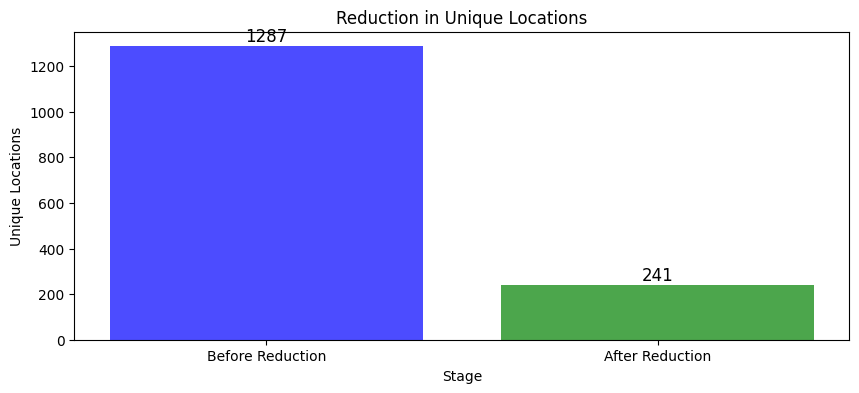

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# Given values
before_counts = 1287
after_counts = 241
difference = before_counts - after_counts

plt.figure(figsize=(10, 4))

# Bar plot to show the reduction
plt.bar(['Before Reduction', 'After Reduction'], [before_counts, after_counts], color=['blue', 'green'], alpha=0.7)
plt.xlabel('Stage')
plt.ylabel('Unique Locations')
plt.title('Reduction in Unique Locations')

# Annotate values
plt.text(0, before_counts + 20, str(before_counts), ha='center', fontsize=12)
plt.text(1, after_counts + 20, str(after_counts), ha='center', fontsize=12)



<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [111]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [112]:
df5.shape

(13200, 7)

In [113]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

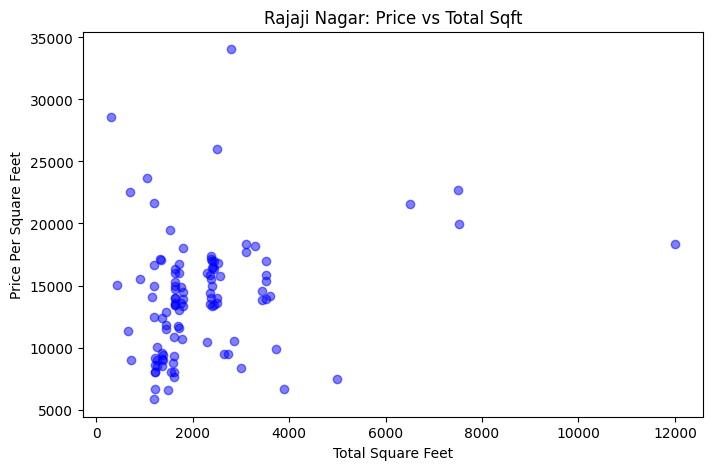

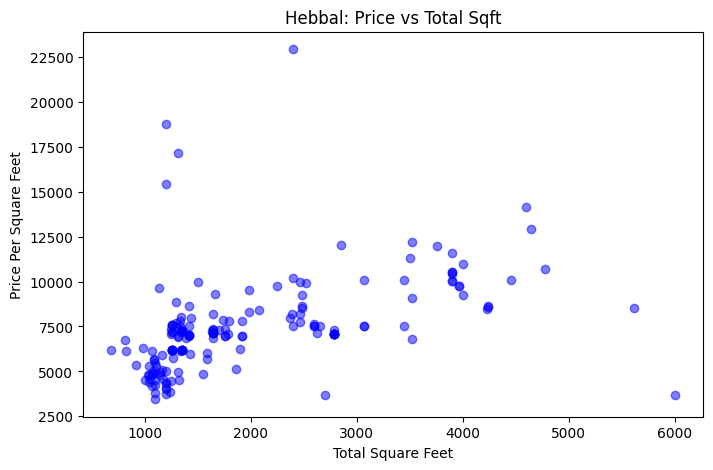

In [114]:
import matplotlib.pyplot as plt

# Function to plot scatter chart
def plot_scatter_chart(df, location):
    df_filtered = df[df['location'] == location]
    
    plt.figure(figsize=(8, 5))
    plt.scatter(df_filtered['total_sqft'], df_filtered['price_per_sqft'], color='blue', alpha=0.5)
    plt.xlabel("Total Square Feet")
    plt.ylabel("Price Per Square Feet")
    plt.title(f"{location}: Price vs Total Sqft")
    plt.show()

# Plot for Rajaji Nagar
plot_scatter_chart(df5, "Rajaji Nagar")

# Plot for Hebbal
plot_scatter_chart(df5, "Hebbal")


<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [115]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [116]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

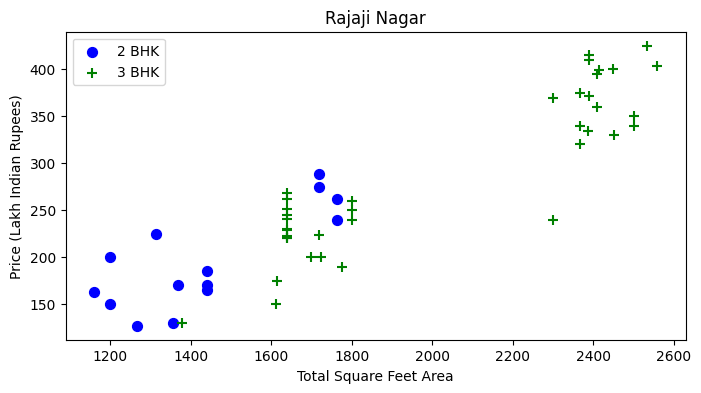

In [117]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (8,4)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

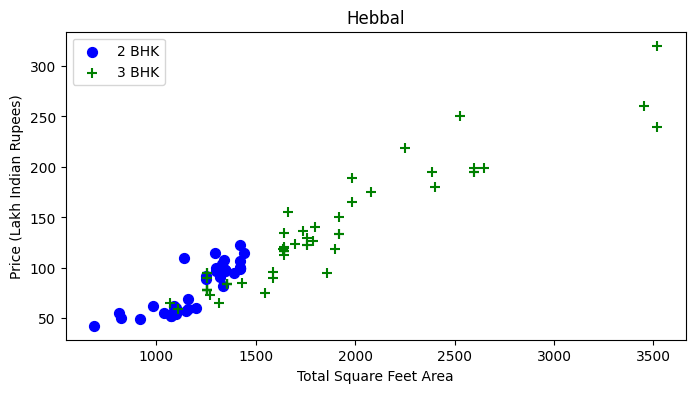

In [118]:
plot_scatter_chart(df7,"Hebbal")

C:\Users\KIIT\AppData\Local\Temp\ipykernel_1568\3964946289.py:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(removed_3bhk.total_sqft, removed_3bhk.price, marker='+', color='red', label='Removed 3 BHK Outliers', s=70, edgecolors='black')


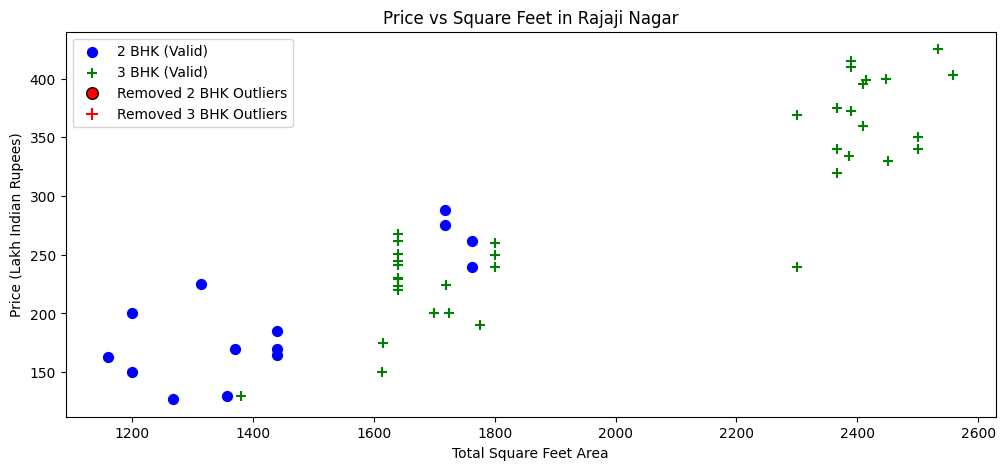

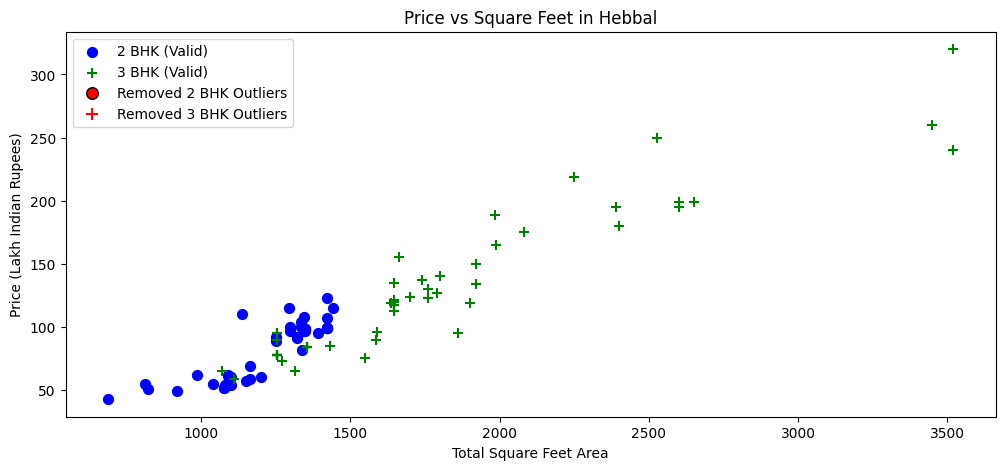

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_scatter_chart_with_outliers(df_before, df_after, location):
    # Get 2 BHK and 3 BHK data before outlier removal
    bhk2_before = df_before[(df_before.location == location) & (df_before.bhk == 2)]
    bhk3_before = df_before[(df_before.location == location) & (df_before.bhk == 3)]
    
    # Get 2 BHK and 3 BHK data after outlier removal
    bhk2_after = df_after[(df_after.location == location) & (df_after.bhk == 2)]
    bhk3_after = df_after[(df_after.location == location) & (df_after.bhk == 3)]
    
    # Find removed outliers (points in df_before but not in df_after)
    removed_2bhk = bhk2_before[~bhk2_before.index.isin(bhk2_after.index)]
    removed_3bhk = bhk3_before[~bhk3_before.index.isin(bhk3_after.index)]

    # Set figure size
    plt.figure(figsize=(12, 5))
    
    # Plot valid data points after cleaning
    plt.scatter(bhk2_after.total_sqft, bhk2_after.price, color='blue', label='2 BHK (Valid)', s=50)
    plt.scatter(bhk3_after.total_sqft, bhk3_after.price, marker='+', color='green', label='3 BHK (Valid)', s=50)
    
    # Plot removed outliers in red
    plt.scatter(removed_2bhk.total_sqft, removed_2bhk.price, color='red', label='Removed 2 BHK Outliers', s=70, edgecolors='black')
    plt.scatter(removed_3bhk.total_sqft, removed_3bhk.price, marker='+', color='red', label='Removed 3 BHK Outliers', s=70, edgecolors='black')

    # Labels and Title
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(f"Price vs Square Feet in {location}")
    plt.legend()
    
    # Show Plot
    plt.show()

# Example usage
plot_scatter_chart_with_outliers(df7, df7, "Rajaji Nagar")
plot_scatter_chart_with_outliers(df7, df7,  "Hebbal")


**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [120]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

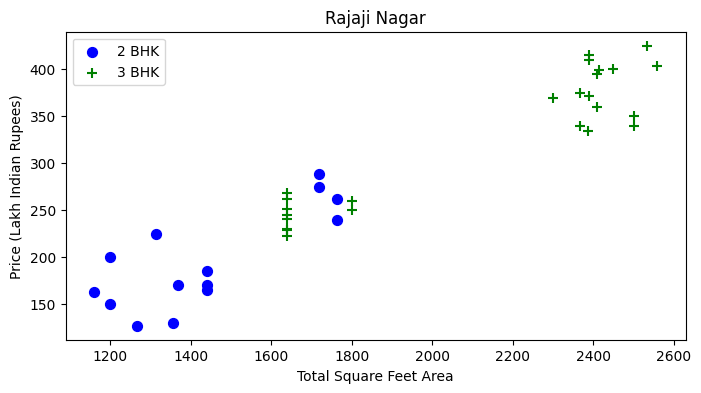

In [121]:
plot_scatter_chart(df8,"Rajaji Nagar")

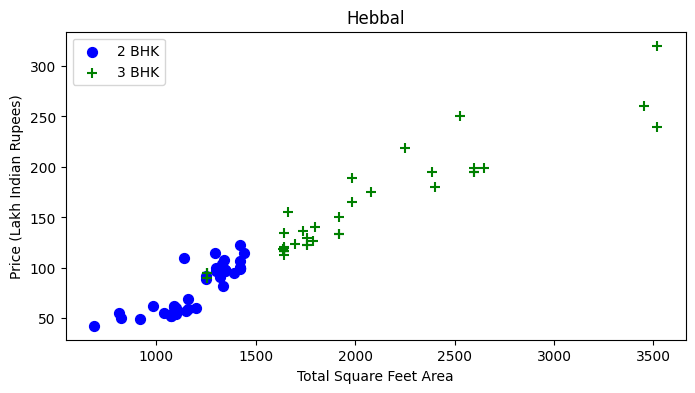

In [122]:
plot_scatter_chart(df8,"Hebbal")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

<h3 style='color:green'>Before and after outlier removal: Rajaji Nagar</h3>

<img src="rajaji_nagar_outliers.png"></img>

<h3 style='color:green'>Before and after outlier removal: Hebbal</h3>

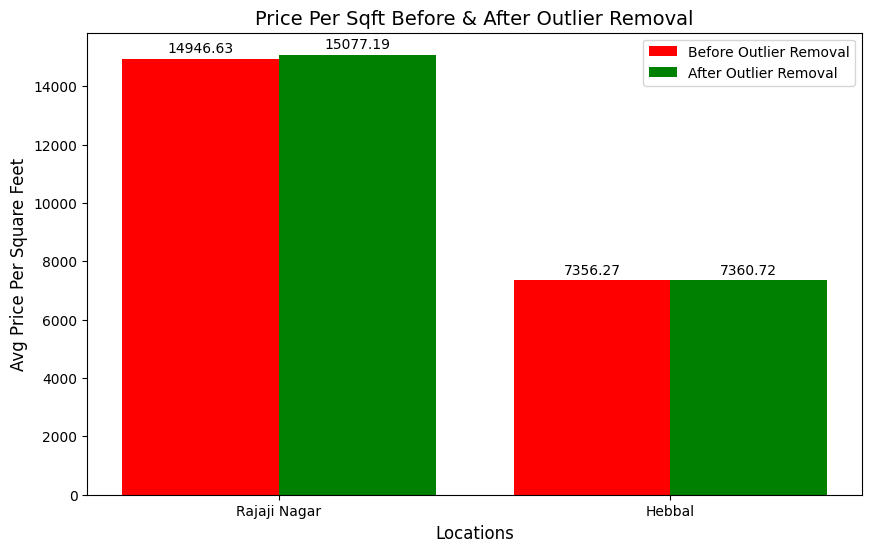

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to calculate mean prices before and after outlier removal
def get_mean_price(df, location):
    df_before = df[df['location'] == location]
    df_after = df_before[
        (df_before['price_per_sqft'] > df_before['price_per_sqft'].quantile(0.05)) & 
        (df_before['price_per_sqft'] < df_before['price_per_sqft'].quantile(0.95))
    ]
    return df_before['price_per_sqft'].mean(), df_after['price_per_sqft'].mean()

# Getting mean values for Rajaji Nagar and Hebbal
mean_before_rajaji, mean_after_rajaji = get_mean_price(df8, "Rajaji Nagar")
mean_before_hebbal, mean_after_hebbal = get_mean_price(df8, "Hebbal")

# Data for plotting
locations = ["Rajaji Nagar", "Hebbal"]
before_prices = [mean_before_rajaji, mean_before_hebbal]
after_prices = [mean_after_rajaji, mean_after_hebbal]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.4
x = np.arange(len(locations))

bars1 = ax.bar(x - bar_width/2, before_prices, bar_width, label="Before Outlier Removal", color="red")
bars2 = ax.bar(x + bar_width/2, after_prices, bar_width, label="After Outlier Removal", color="green")

# Adding labels
ax.set_xlabel("Locations", fontsize=12)
ax.set_ylabel("Avg Price Per Square Feet", fontsize=12)
ax.set_title("Price Per Sqft Before & After Outlier Removal", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(locations)
ax.legend()

# Adding value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 200, f"{height:.2f}", ha='center', fontsize=10)

# Show plot
plt.show()


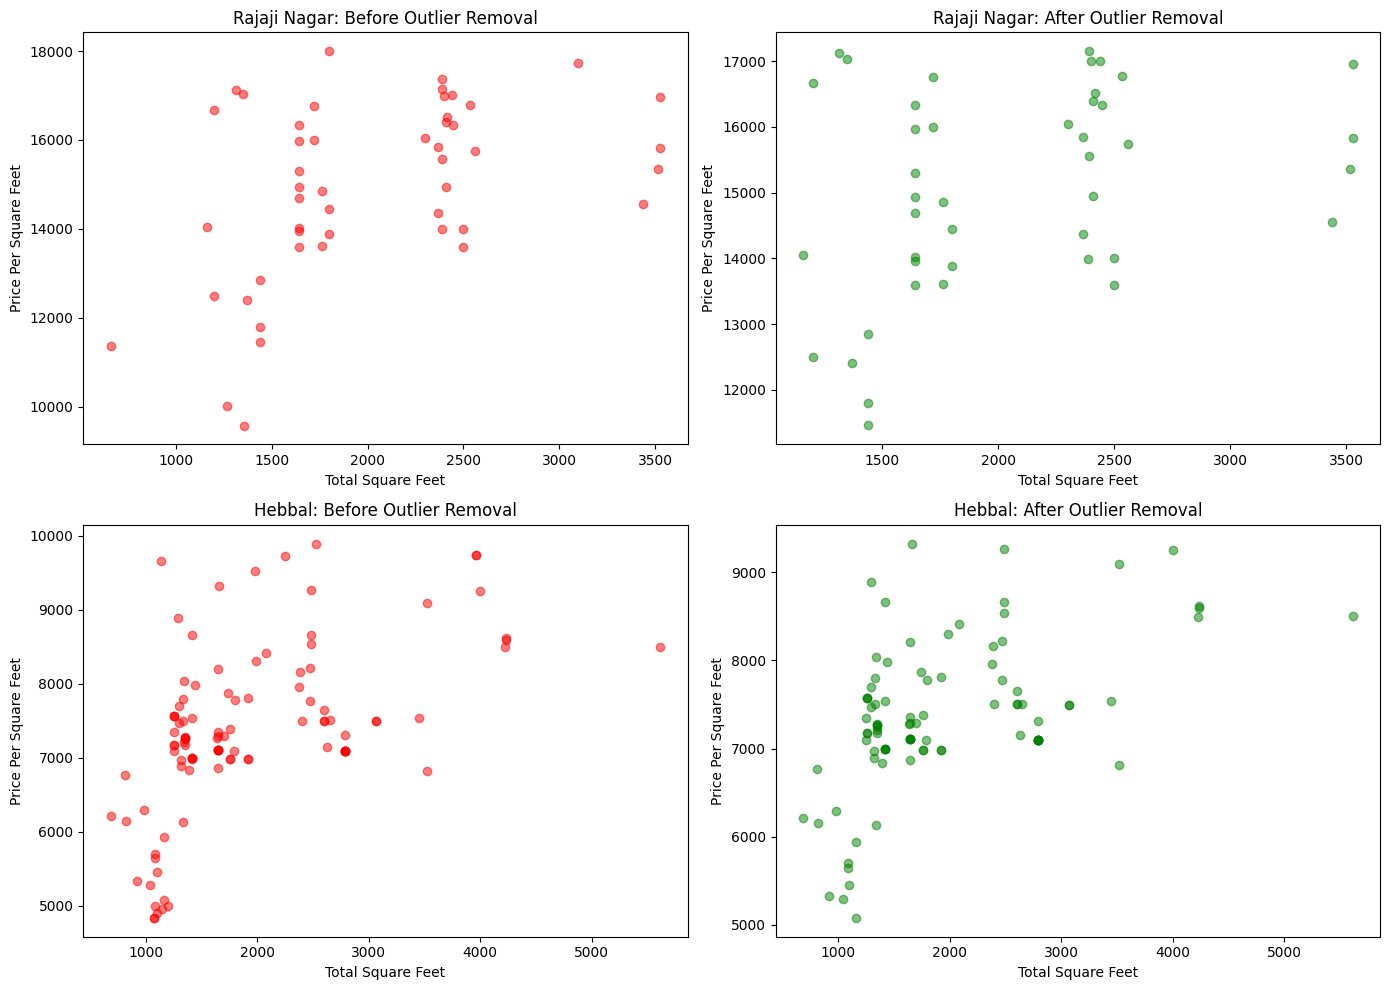

In [124]:
import matplotlib.pyplot as plt

# Function to filter data before and after outlier removal
def filter_data(df, location):
    df_before = df[df['location'] == location]
    df_after = df_before[
        (df_before['price_per_sqft'] > df_before['price_per_sqft'].quantile(0.05)) & 
        (df_before['price_per_sqft'] < df_before['price_per_sqft'].quantile(0.95))
    ]
    return df_before, df_after

# Get data for Rajaji Nagar & Hebbal (Before & After Outlier Removal)
df8_rajaji_before, df8_rajaji_after = filter_data(df8, "Rajaji Nagar")
df8_hebbal_before, df8_hebbal_after = filter_data(df8, "Hebbal")

# Create Subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rajaji Nagar Before Outlier Removal
axes[0, 0].scatter(df8_rajaji_before['total_sqft'], df8_rajaji_before['price_per_sqft'], color='red', alpha=0.5)
axes[0, 0].set_xlabel("Total Square Feet")
axes[0, 0].set_ylabel("Price Per Square Feet")
axes[0, 0].set_title("Rajaji Nagar: Before Outlier Removal")

# Rajaji Nagar After Outlier Removal
axes[0, 1].scatter(df8_rajaji_after['total_sqft'], df8_rajaji_after['price_per_sqft'], color='green', alpha=0.5)
axes[0, 1].set_xlabel("Total Square Feet")
axes[0, 1].set_ylabel("Price Per Square Feet")
axes[0, 1].set_title("Rajaji Nagar: After Outlier Removal")

# Hebbal Before Outlier Removal
axes[1, 0].scatter(df8_hebbal_before['total_sqft'], df8_hebbal_before['price_per_sqft'], color='red', alpha=0.5)
axes[1, 0].set_xlabel("Total Square Feet")
axes[1, 0].set_ylabel("Price Per Square Feet")
axes[1, 0].set_title("Hebbal: Before Outlier Removal")

# Hebbal After Outlier Removal
axes[1, 1].scatter(df8_hebbal_after['total_sqft'], df8_hebbal_after['price_per_sqft'], color='green', alpha=0.5)
axes[1, 1].set_xlabel("Total Square Feet")
axes[1, 1].set_ylabel("Price Per Square Feet")
axes[1, 1].set_title("Hebbal: After Outlier Removal")

# Adjust Layout
plt.tight_layout()
plt.show()


In [125]:
df8.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


<img src="hebbal_outliers.png"></img>

Text(0, 0.5, 'Count')

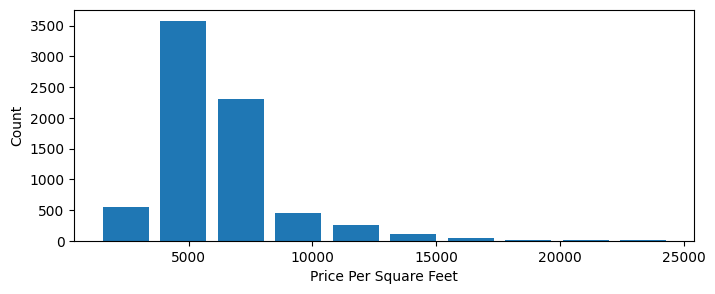

In [126]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (8,3)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [127]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

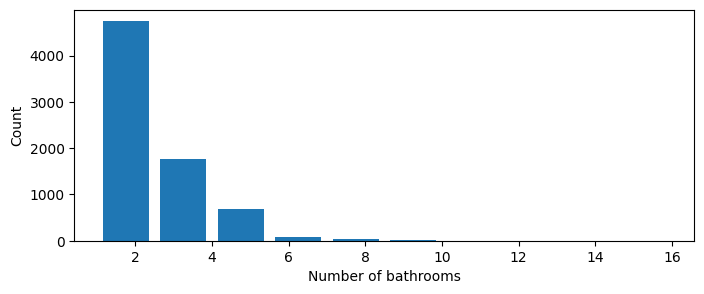

In [128]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [129]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [130]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [131]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 7)

In [132]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [133]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


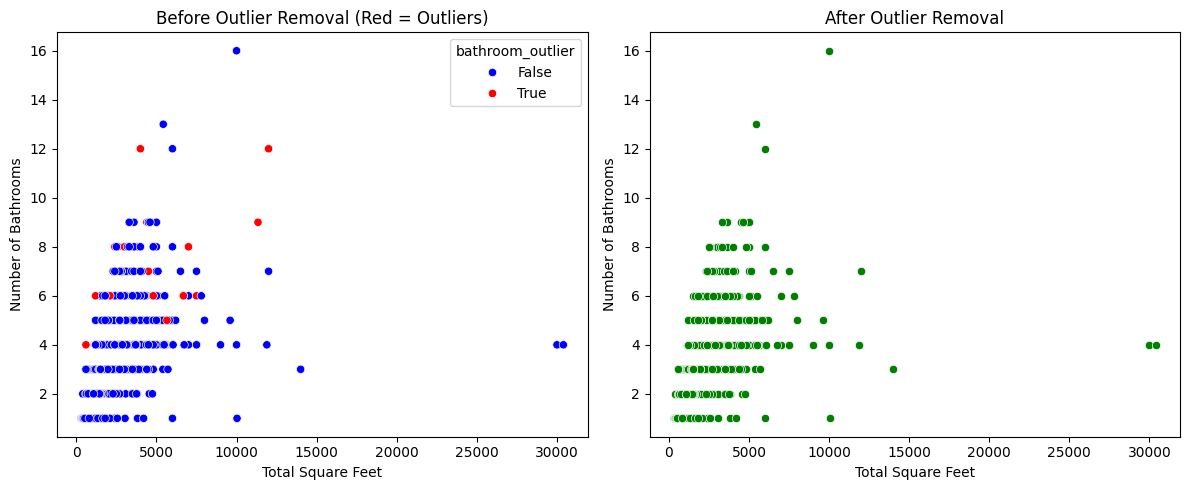

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identifying outliers where bathrooms > bedrooms + 1
df7['bathroom_outlier'] = df7['bath'] > (df7['bhk'] + 1)

# Function to plot scatter plots before and after outlier removal
def plot_bathroom_outlier_removal(df):
    plt.figure(figsize=(12, 5))

    # Scatter plot before outlier removal
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=df['total_sqft'], y=df['bath'], hue=df['bathroom_outlier'], palette={True: 'red', False: 'blue'})
    plt.xlabel("Total Square Feet")
    plt.ylabel("Number of Bathrooms")
    plt.title("Before Outlier Removal (Red = Outliers)")
    
    # Remove outliers
    df_cleaned = df[df['bath'] <= (df['bhk'] + 1)]

    # Scatter plot after outlier removal
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=df_cleaned['total_sqft'], y=df_cleaned['bath'], color='green')
    plt.xlabel("Total Square Feet")
    plt.ylabel("Number of Bathrooms")
    plt.title("After Outlier Removal")

    plt.tight_layout()
    plt.show()

# Run the function to visualize before and after outlier removal
plot_bathroom_outlier_removal(df7)


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [135]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [136]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [137]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h2 style='color:blue'>Build a Model Now...</h2>

In [138]:
df12.shape

(7239, 244)

In [139]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [140]:
X.shape

(7239, 243)

In [141]:
y = df12.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [142]:
len(y)

7239

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [144]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8629132245229443

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [156]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=7, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502,
       0.7996843 , 0.8546295 ])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [146]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor

def evaluate_models(X, y):
    # Define models and hyperparameters
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'Lasso Regression': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'Decision Tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    # Apply GridSearchCV to each model
    for model_name, model_config in models.items():
        gs = GridSearchCV(model_config['model'], model_config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)

        # Store model accuracy scores and best parameters
        scores.append({
            'Model': model_name,
            'Best Score': round(gs.best_score_ * 100, 2),  # Convert score to percentage
            'Best Params': gs.best_params_
        })

        print(f"{model_name}: Best Score = {gs.best_score_:.4f}, Best Params = {gs.best_params_}")

    # Convert results into a DataFrame
    results = pd.DataFrame(scores, columns=['Model', 'Best Score', 'Best Params'])
    return results



**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

<h2 style='color:blue'>Test the model for few properties</h2>

In [147]:
import numpy as np
import pandas as pd

def predict_price(location, sqft, bhk, bath):
    loc_index = np.where(X.columns == location)[0][0] if location in X.columns else -1

    # Create a DataFrame with feature names
    input_data = np.zeros(len(X.columns))
    input_data[0] = sqft
    input_data[1] = bath
    input_data[2] = bhk
    if loc_index >= 0:
        input_data[loc_index] = 1  # Set location one-hot encoded value

    # Convert input to DataFrame with column names
    input_df = pd.DataFrame([input_data], columns=X.columns)

    return lr_clf.predict(input_df)[0]  # Make prediction using Linear Regression model




In [148]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

np.float64(83.8657025831225)

In [149]:
predict_price('1st Phase JP Nagar',500, 2, 2)

np.float64(43.806750981547516)

In [150]:
predict_price('Indira Nagar',1000, 3, 3)

np.float64(195.52689759854673)

In [151]:
predict_price('Indira Nagar',1000, 2, 3)

np.float64(197.02892403856663)

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [152]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [153]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

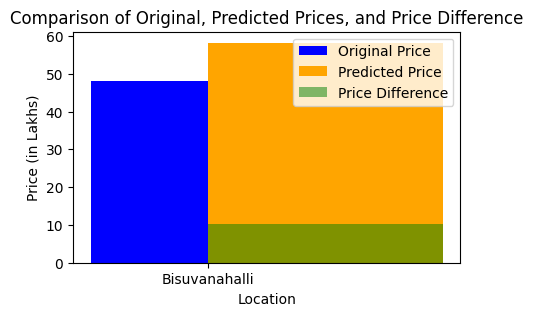

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Data for original and predicted prices
locations = ['Bisuvanahalli']
original_prices = [48]  # in Lakh
predicted_prices = [58.2]  # in Lakh

# Calculate the price difference
price_difference = np.array(predicted_prices) - np.array(original_prices)

# Plotting the bar chart with the difference
plt.figure(figsize=(5, 3))
bar_width = 0.3

# Plotting the original and predicted prices
plt.bar(locations, original_prices, width=bar_width, label='Original Price', color='blue', align='center')
plt.bar(locations, predicted_prices, width=bar_width, label='Predicted Price', color='orange', align='edge')

# Adding a separate bar for the difference
plt.bar(locations, price_difference, width=bar_width, label='Price Difference', color='green', align='edge', alpha=0.5)

# Adding labels and title
plt.xlabel('Location')
plt.ylabel('Price (in Lakhs)')
plt.title('Comparison of Original, Predicted Prices, and Price Difference')
plt.legend()

# Show the plot
plt.show()
